## API Management Introduction:








The API management dataset is a log of providers, endpoints, and consumers that are part of an API management system. When a consumer uses a provider endpoint through API management, this dataset logs information about the transaction, including response time, method, gateway type, and payment type. This dataset contains approximately one million transactions between different providers and consumers.

The dataset provided is generated using real data, ensuring its authenticity and relevance. It incorporates all existing relationships and connections between the columns, accurately representing the interactions and dependencies found in the original data. Furthermore, the dataset encompasses the complete dispersion or variability for each column, capturing the full range of values and patterns observed in the real-world data. This comprehensive representation allows for a thorough analysis and exploration of the dataset, enabling meaningful insights to be derived from the various attributes and their interplay.


Here is a detailed explanation of each column in the dataset:

- log_level: Represents the level or severity of the log message. In the sample, values include "WARNING" and "ERROR" indicating different levels of warning or error events.

- code: Indicates the specific code associated with the log event. It may represent an error code, HTTP status code, or any other relevant code. Sample values include 429, 335, 404, and 400.
 
- method: Denotes the HTTP method used in the API request. It specifies the type of action performed on the endpoint. Examples in the sample include "POST" and "GET".

- username: Refers to the username associated with the API request or operation. It identifies the user initiating the action. In the sample, values are labeled as "username_1376".

- Price: Represents the price associated with the API request or operation. It signifies the cost or monetary value related to the action. Sample values include 10, 20, and 50.

- gwStatus: Indicates the status of the gateway. It may represent the operational status or any other relevant status of the gateway system. In the sample, values are labeled as 0 (presumably indicating an inactive status).

- planName: Represents the name of the plan associated with the API request or operation. It denotes the subscription or service plan chosen for the action. Sample values include "Silver", "Bronze", and "Gold".

- received_at: Represents the timestamp indicating when the API request was received. It provides the date and time information of the request. In the sample, values are in a timestamp format.

- log_type: Specifies the type of log event. It categorizes the log entry based on its purpose or nature. Sample values include "INPUT" and "OUTPUT".

- providerName: Refers to the name of the API provider. It represents the entity or organization providing the API services. In the sample, values are labeled as "provider_186".

- gatewayName: Represents the name of the gateway associated with the API request or operation. It signifies the gateway through which the request was processed. Sample values include "gateway_657".

- response_status: Indicates the HTTP response status code associated with the API request. It represents the outcome or result of the request. Sample values include 200, 400, and 403.

- status: Denotes the status of the API request or operation. It represents the success or failure status of the action. In the sample, values are labeled as 1 or 0, indicating success or failure, respectively.

- response_Time: Represents the time taken for the API response to be processed. It measures the duration between the request and response. Sample values include 958, 576, and 342.

- paymentType: Indicates the payment type associated with the API request or operation. It denotes the method or type of payment used. Sample values include "PREPAID" and "POSTPAID".

- endpoint: Refers to the specific endpoint or URL path targeted by the API request. It represents the location or resource being accessed. Sample values include "endpoint_1201".

- providerResponse_Time: Represents the response time of the API provider. It measures the duration taken by the provider to process the request and generate a response. Sample values include 479, 288, and 197.

- gwCode: Denotes the gateway code associated with the API request or operation. It represents a specific code or identifier related to the gateway system. Sample values include



The goal of this project is to analyze an API management dataset to gain insights into API usage and performance within an organization. The dataset consists of various columns such as log_level, code, method, username, Price, gwStatus, planName, received_at, log_type, providerName, gatewayName, response_status, status, response_Time, paymentType, endpoint, providerResponse_Time, gwCode, call_type, and api_type.

The project is divided into three main phases: data cleaning, exploration, and feature engineering. During the data cleaning phase, various data quality issues is addressed, such as missing values, duplicates, and outliers. In the exploration phase, the cleaned dataset is visualized and analyzed to gain insights into the distribution of the data and identify any patterns or trends. Finally, in the feature engineering phase, new features are created to help improve the accuracy of the analysis.

By completing these phases, the project aim to provide valuable insights into API usage and performance, which could help inform decision-making within the organization. The project is a critical step towards understanding and optimizing the organization's API management strategy.


## Import important libraries and read data

In [4]:
! pip install -q plotly_express

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly_express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [6]:
df = pd.read_parquet('api_management_clean.parquet')

## Overview

In [7]:
df.shape

(1000000, 20)

In [8]:
df.head()

,log_level,code,method,username,Price,gwStatus,planName,received_at,log_type,providerName,gatewayName,response_status,status,response_Time,paymentType,endpoint,providerResponse_Time,gwCode,call_type,api_type
0,WARNING,429,POST,username_1376,10,0,Silver,2022-06-28T10:24:46.000000Z,INPUT,provider_186,gateway_657,200,1,958,PREPAID,endpoint_1201,479,600,EXTERNAL,undefined
1,WARNING,335,GET,username_1376,10,0,Bronze,2021-09-18T05:43:21.000000Z,OUTPUT,provider_186,gateway_657,400,0,576,POSTPAID,endpoint_1201,288,404,EXTERNAL,undefined
2,WARNING,404,POST,username_1376,20,0,Gold,2022-04-03T03:52:45.000000Z,OUTPUT,provider_186,gateway_657,401,0,395,POSTPAID,endpoint_1201,197,300,INTERNAL,oauth
3,ERROR,400,POST,username_1376,20,0,Bronze,2023-02-14T18:38:42.000000Z,INPUT,provider_186,gateway_657,200,1,342,POSTPAID,endpoint_1201,171,408,INTERNAL,undefined
4,WARNING,429,GET,username_1376,50,0,Bronze,2021-07-12T11:09:06.000000Z,OUTPUT,provider_186,gateway_657,403,0,330,PREPAID,endpoint_1201,165,404,EXTERNAL,undefined


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   log_level              1000000 non-null  object
 1   code                   1000000 non-null  object
 2   method                 1000000 non-null  object
 3   username               1000000 non-null  object
 4   Price                  1000000 non-null  object
 5   gwStatus               1000000 non-null  object
 6   planName               1000000 non-null  object
 7   received_at            1000000 non-null  object
 8   log_type               1000000 non-null  object
 9   providerName           1000000 non-null  object
 10  gatewayName            1000000 non-null  object
 11  response_status        1000000 non-null  object
 12  status                 1000000 non-null  object
 13  response_Time          1000000 non-null  int64 
 14  paymentType            1000000 non-

## Data Cleaning and Handling 


### Check Nulls

In [10]:
df.isnull().sum()

log_level                0
code                     0
method                   0
username                 0
Price                    0
gwStatus                 0
planName                 0
received_at              0
log_type                 0
providerName             0
gatewayName              0
response_status          0
status                   0
response_Time            0
paymentType              0
endpoint                 0
providerResponse_Time    0
gwCode                   0
call_type                0
api_type                 0
dtype: int64

### Check Duplicates

In [11]:
duplicates = df[df.duplicated()]

if len(duplicates) > 0:
    print("Duplicates found!")
    print(duplicates)
else:
    print("No duplicates found.")

No duplicates found.


### Response times cant be zero

In [12]:
df[(df["providerResponse_Time"] == 0) | (df["response_Time"] == 0)].count()[0]

5001

These rows should be dropped

In [13]:
df = df.drop(df[(df["providerResponse_Time"] == 0) | (df["response_Time"] == 0)].index).reset_index(drop = True)

### Dealing with outliers

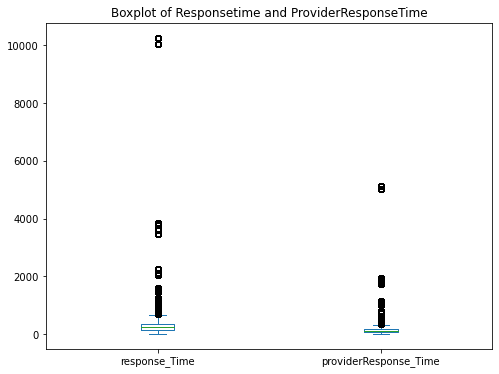

In [14]:
df.plot( kind = "box", figsize = (8,6), title = 'Boxplot of Responsetime and ProviderResponseTime')
plt.show()

In [15]:
def lower_upper_bound_finder(column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)

    LB = Q1 - 1.5 * (Q3 - Q1)
    UB = Q3 + 1.5 * (Q3 - Q1)

    print(f''' The lower bound for {column_name} feature is {LB}\n The higher bound for {column_name} feature is {UB}''')
    
    return LB,UB


The `lower_upper_bound_finder(column_name)` function detects and replaces outliers in a specified column of a DataFrame using the interquartile range (IQR) method. It calculates the lower bound (LB) and upper bound (UB) based on the first quartile (Q1) and third quartile (Q3) of the column, which define a range within which data points are considered non-outliers. The function prints the lower and upper bounds and returns them as a tuple.


In [16]:
LB_provider_response_time, UB_provider_response_time = lower_upper_bound_finder('providerResponse_Time')

 The lower bound for providerResponse_Time feature is -77.0
 The higher bound for providerResponse_Time feature is 331.0


In [17]:
LB_response_time, UB_response_time = lower_upper_bound_finder('response_Time')

 The lower bound for response_Time feature is -155.5
 The higher bound for response_Time feature is 664.5


### Explore important features

In [18]:
def create_displot(column_name, title ):
    # Calculate the mean and standard deviation of the column 
    mean_A = df[column_name].mean()
    std_A = df[column_name].std()

    # Find outliers greater than mean + 2 std and smaller than mean - 2 std
    outliers = df.loc[(df[column_name] > mean_A + 2*std_A) | (df[column_name] < mean_A - 2*std_A), column_name]

    # Replace outliers with the mean value of the column 
    for index in outliers.index:
        df.loc[index, column_name] = mean_A

    sns.displot(df[column_name],color='red',bins=100,height=5, aspect=2).fig.suptitle(title)
    plt.show()

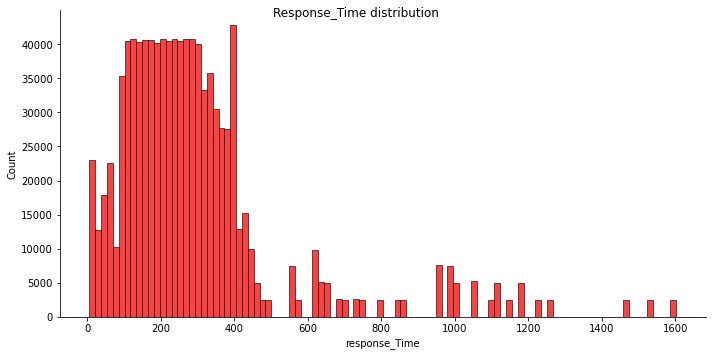

In [19]:
create_displot('response_Time', 'Response_Time distribution' )

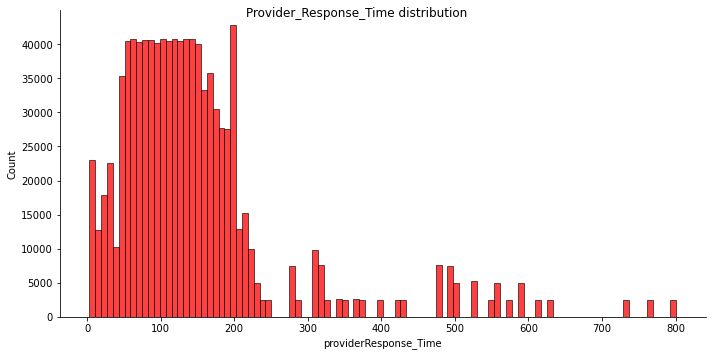

In [20]:
create_displot('providerResponse_Time', 'Provider_Response_Time distribution' )

### Dealing with Boolean and Numbers

These columns can be replace with boolian values:

 **log_level, method, planName, log_type, paymentType, call_type, api_type** 

 or in **planName** case they can encode with ordinary numbers like 1 2 3.

 **BUT** we keep them as they are, cause at the moment we dont have plan for any ML models.

In [21]:
df["code"] = df["code"].apply(lambda x : int(x))
df["Price"] = df["Price"].astype(int)
df["gwStatus"] = df["gwStatus"].astype(bool)
df["response_status"] = df["response_status"].astype(int)
df["status"] = df["status"].astype(bool)
df["gwCode"] = df["gwCode"].astype(int)

In [22]:
df.dtypes

log_level                 object
code                       int64
method                    object
username                  object
Price                      int64
gwStatus                    bool
planName                  object
received_at               object
log_type                  object
providerName              object
gatewayName               object
response_status            int64
status                      bool
response_Time            float64
paymentType               object
endpoint                  object
providerResponse_Time    float64
gwCode                     int64
call_type                 object
api_type                  object
dtype: object

## EDA

In [23]:
# finding top five
def top5_plot(column_name, color = 'pink'):
    plt.figure(figsize=(16, 4))
    plt.bar(df[column_name].value_counts()[0:5].index,df[column_name].value_counts()[0:5].values,color=color)
    plt.title(f"Top Five {column_name}")
    plt.show()


The `top5_plot(column_name, color='pink')` function creates a bar plot to display the top five most frequent values in a specified column of a DataFrame. It uses the `value_counts()` function to count the occurrences of each unique value, selects the top five values, and plots them as bars. The color of the bars can be optionally specified using the `color` parameter, which defaults to 'pink'. The plot includes a title indicating the column being analyzed.


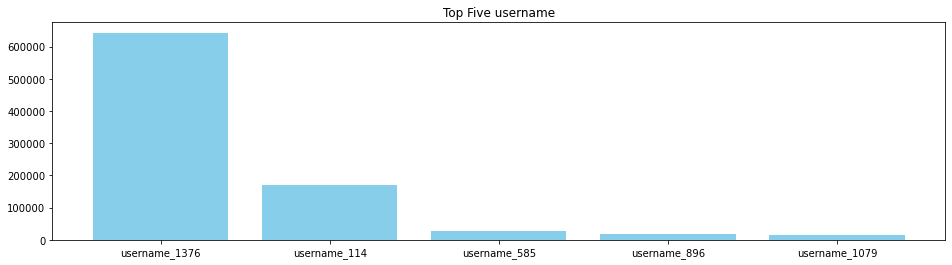

In [24]:
top5_plot('username','skyblue')

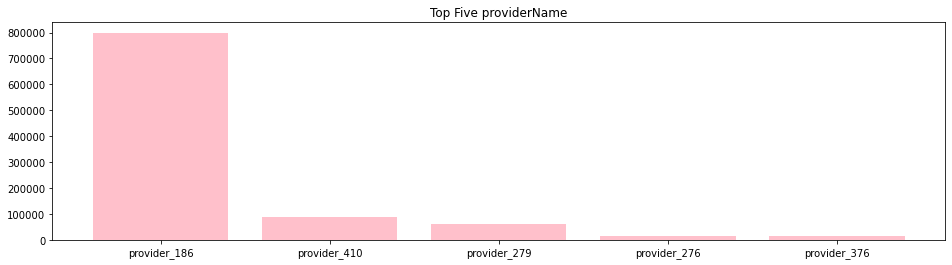

In [25]:
top5_plot('providerName')

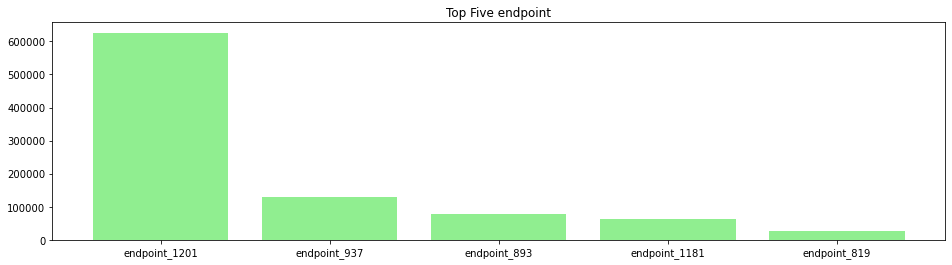

In [26]:
top5_plot('endpoint','lightgreen')

In [27]:
def create_pie(column_name, title):
    plt.figure(figsize=(4, 8))
    value_count = df[column_name].value_counts()
    plt.pie(
            value_count.values,
            labels = value_count.index,
            colors = ['teal','skyblue'],
            autopct =  '%1.1f%%'
            )
    plt.title(title)
    plt.show()

The `create_pie(column_name, title)` function generates a pie chart to visualize the distribution of values in a specified column of a DataFrame. It uses `plt.pie()` to create the chart with values obtained from the value counts of the column. The chart includes labels, colors, and autopct for percentage display. The title is set using `plt.title()`, and the chart is displayed using `plt.show()`.

In [28]:
def count_percentage_plot_by_column(column_name,given_title,color_name = 'aqua',vertical = True):
    # global available_colors
    global df
    if column_name not in df.columns.tolist():
        raise Exception(f"Column with name '{column_name}' doesnt exists.")
    # if color_name not in available_colors:
    #     raise Exception(f"Color with name '{color_name}' doesnt exists.")
    count_percentage = [ round(i,2) for i in df[column_name].value_counts().values / df.shape[0] * 100]
    uniques_values = df[column_name].value_counts().index
    result = pd.DataFrame(
        {
            column_name : uniques_values,
            "count_percentage" : count_percentage
        }
    )
    if vertical:
        fig = px.bar(result, x = column_name, y = "count_percentage")
    else:
        fig = px.bar(result.sort_values('count_percentage'), y = column_name, x = "count_percentage",orientation='h')
    fig.update_layout(autosize=False,
    width=800,
    height=400,
    title = given_title,
    title_x=0.5
    )
    fig.update_traces(marker=dict(color= color_name))
    fig.show()

The ` count_percentage_plot_by_column(column_name, given_title, color_name='aqua', vertical=True)` function generates a bar plot using Plotly Express to visualize the count percentage of unique values in a specified column of a DataFrame. It calculates the count percentage for each unique value, creates a DataFrame with the values and count percentages, and plots a bar chart with either vertical or horizontal orientation based on the vertical parameter. The plot's title, color, and dimensions are customized, and the resulting plot is displayed.

In [29]:
count_percentage_plot_by_column('log_level','Percentage of Log levels','aqua',False)

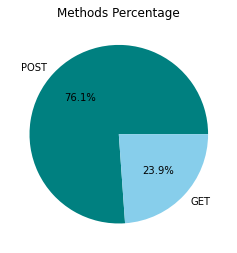

In [30]:
create_pie('method','Methods Percentage')

In [31]:
count_percentage_plot_by_column('Price','Different Prices Percentage','midnightblue',False)

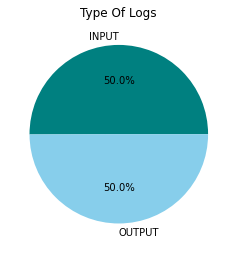

In [32]:
create_pie('log_type','Type Of Logs')

In [33]:
count_percentage_plot_by_column('planName','Different Plan Names','purple')

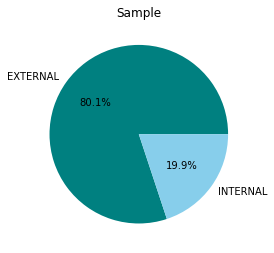

In [34]:
create_pie('call_type','Sample')

In [35]:
count_percentage_plot_by_column('api_type','Different API Types','pink',False)

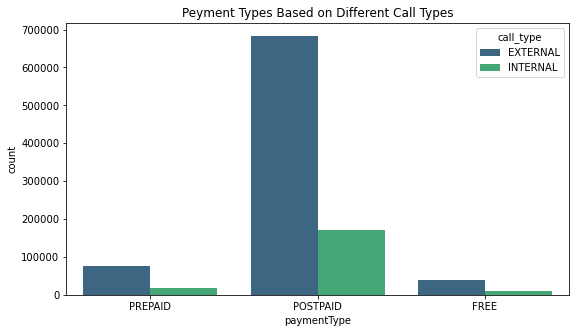

In [36]:
plt.figure(figsize=(9, 5))
sns.countplot(x='paymentType',data=df,hue='call_type',palette='viridis').set_title("Peyment Types Based on Different Call Types")
plt.show()

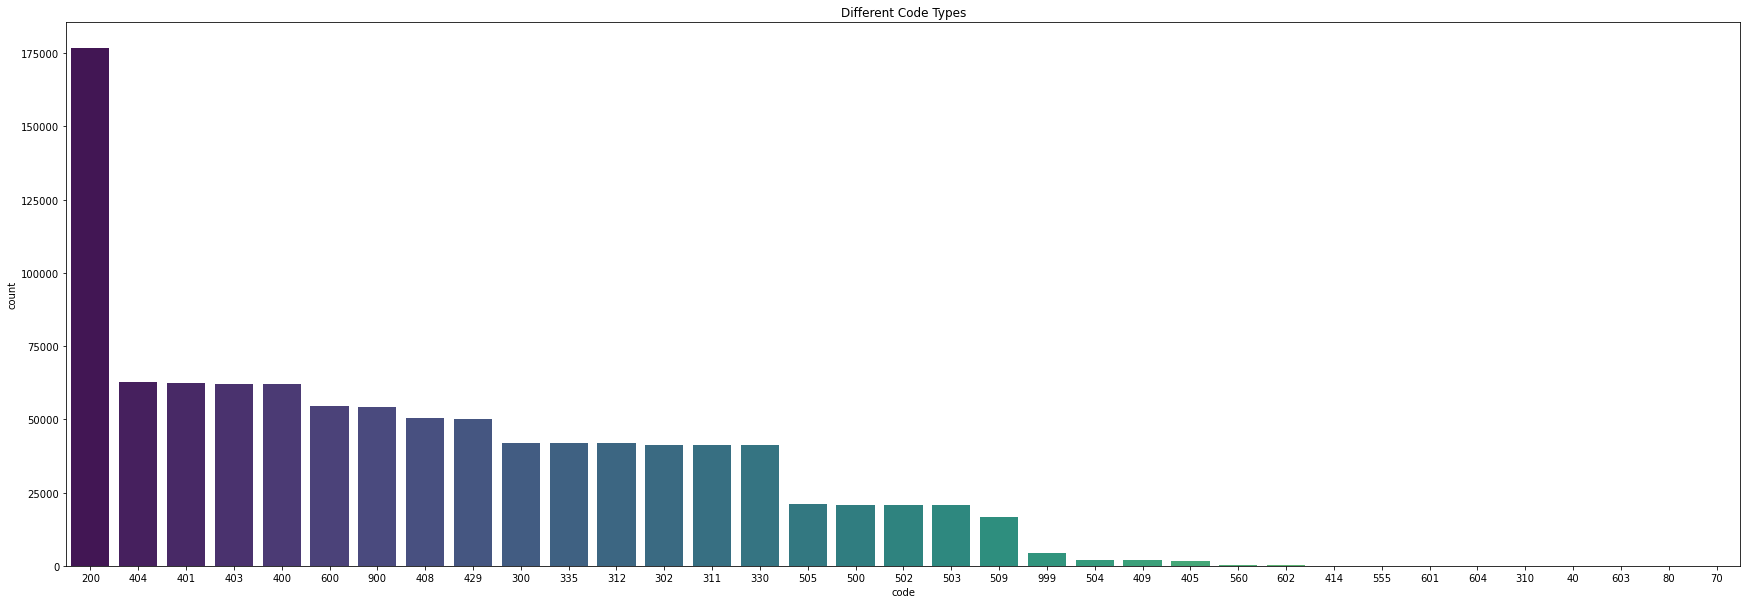

In [37]:
plt.figure(figsize=(30,10))
sns.countplot(x='code',data=df,palette='viridis',order=df['code'].value_counts().index).set_title("Different Code Types")
plt.show()

In [38]:
succesfull_transaction = go.Figure()
succesfull_transaction.add_trace(go.Indicator(
mode = "number+delta",
number = {'suffix': '%'},
value = sum(df['status'])/len(df)*100,
domain = {'row': 0, 'column': 1}))
succesfull_transaction.update_layout(autosize=False,
width=400,
height=400,
    title={
    'text': f"Successfull Transaction",
    'y':0.9,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'}
)
succesfull_transaction.show()

In [39]:
sum(df['status'])/len(df)*100

100.0

## Feature Engineering and More Insight

### Latency

Latency means the diffrence between response_time and providerResponse_Time.

The latency shows the api management platfrom response time. 

In [40]:
df["latency"] = df["response_Time"] - df["providerResponse_Time"]

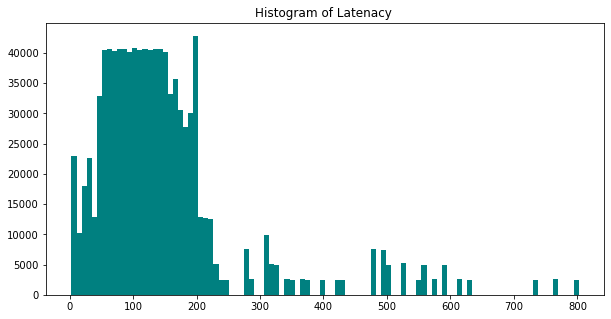

In [41]:
plt.figure(figsize=(10, 5))
plt.hist(df["latency"],color='teal', bins = 100)
plt.title("Histogram of Latenacy ")
plt.show()

In [42]:
# ERROR AND GOLD PLAN
error_and_goldplan = round( df[(df["log_level"] == "ERROR") & (df["planName"] == "Gold")].shape[0],2)

In [43]:
# ALL GOLD PLAN
all_goldplan = df[(df["planName"] == "Gold")].shape[0]

We can see the percentage of failed transactions in Gold plan. It is almost 8%

In [44]:
round(error_and_goldplan / all_goldplan * 100,2)

8.27

Because of 92% of good performance in gold plan, we can claim that the problem is from provider side and **not** from api management side.
Now let's check if we have a bad performer provider with huge amount of failed transaction who has a gold plan.

In [45]:
df[(df["log_level"] == "ERROR") & (df["planName"] == "Gold")]["providerName"].value_counts()

provider_186     13220
provider_410      1453
provider_279      1007
provider_276       275
provider_376       232
provider_189        72
provider_290        66
provider_1050       22
provider_562        19
provider_1189       18
provider_800        17
provider_715        12
provider_955        10
provider_89         10
provider_1386        8
provider_1226        6
provider_322         3
provider_457         2
provider_1421        1
Name: providerName, dtype: int64

The Worst one is **provider_186**, after it  provider_410, provider_279, provider_376 respectively. We should notif them to solve the problem.

### Dealing with Date type

In [46]:
# Convert object type to datetime type
df["received_at"] = pd.to_datetime(df["received_at"], utc = True)

In [47]:
# Create some new columns from received_at column
df["received_at_short"] = df["received_at"].dt.date
df["Year"] = df["received_at"].dt.year
df["Month"] = df["received_at"].dt.month
df["Day"] = df["received_at"].dt.day
df['Day of Week'] = df['received_at'].apply(lambda time: time.dayofweek)
df['Hour'] = df['received_at'].apply(lambda time: time.hour)

dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df['Day of Week'] = df['Day of Week'].map(dmap)

### Relations

In [48]:
df.columns

Index(['log_level', 'code', 'method', 'username', 'Price', 'gwStatus',
       'planName', 'received_at', 'log_type', 'providerName', 'gatewayName',
       'response_status', 'status', 'response_Time', 'paymentType', 'endpoint',
       'providerResponse_Time', 'gwCode', 'call_type', 'api_type', 'latency',
       'received_at_short', 'Year', 'Month', 'Day', 'Day of Week', 'Hour'],
      dtype='object')

In [49]:
df.drop(["gwStatus","status"], axis = 1).corr()

,code,Price,response_status,response_Time,providerResponse_Time,gwCode,latency,Year,Month,Day,Hour
code,1.000000,0.001940,0.000993,-0.000741,-0.000742,-0.000986,-0.000741,0.001078,0.000113,0.000442,-0.000688
Price,0.001940,1.000000,0.001057,0.000894,0.000896,0.000227,0.000892,-0.000686,0.000380,0.000952,-0.001048
response_status,0.000993,0.001057,1.000000,0.000352,0.000350,0.000702,0.000354,-0.000868,0.000471,0.000333,0.000147
response_Time,-0.000741,0.000894,0.000352,1.000000,0.999998,-0.000183,0.999998,0.000092,0.000842,0.000465,-0.001281
providerResponse_Time,-0.000742,0.000896,0.000350,0.999998,1.000000,-0.000184,0.999992,0.000092,0.000841,0.000466,-0.001282
gwCode,-0.000986,0.000227,0.000702,-0.000183,-0.000184,1.000000,-0.000183,-0.000127,0.001210,0.000858,0.000364
latency,-0.000741,0.000892,0.000354,0.999998,0.999992,-0.000183,1.000000,0.000091,0.000843,0.000465,-0.001281
Year,0.001078,-0.000686,-0.000868,0.000092,0.000092,-0.000127,0.000091,1.000000,-0.436736,-0.057073,0.000670
Month,0.000113,0.000380,0.000471,0.000842,0.000841,0.001210,0.000843,-0.436736,1.000000,0.005584,-0.001122
Day,0.000442,0.000952,0.000333,0.000465,0.000466,0.000858,0.000465,-0.057073,0.005584,1.000000,0.001168


Because this is the mock data and also a lot our features are categorical, we dont have any correlation between features.

In [50]:
#Grouping trasaction based on month for different codes
byMonth = df.groupby( by=['Month']).count().reset_index()
byMonth200 = df[df['code']==200].groupby('Month').count().reset_index()
byMontherror = df[df['code']!=200].groupby('Month').count().reset_index()
byMonth200.head()

,Month,log_level,code,method,username,Price,gwStatus,planName,received_at,log_type,...,providerResponse_Time,gwCode,call_type,api_type,latency,received_at_short,Year,Day,Day of Week,Hour
0,1,15338,15338,15338,15338,15338,15338,15338,15338,15338,...,15338,15338,15338,15338,15338,15338,15338,15338,15338,15338
1,2,13943,13943,13943,13943,13943,13943,13943,13943,13943,...,13943,13943,13943,13943,13943,13943,13943,13943,13943,13943
2,3,15630,15630,15630,15630,15630,15630,15630,15630,15630,...,15630,15630,15630,15630,15630,15630,15630,15630,15630,15630
3,4,14174,14174,14174,14174,14174,14174,14174,14174,14174,...,14174,14174,14174,14174,14174,14174,14174,14174,14174,14174
4,5,14550,14550,14550,14550,14550,14550,14550,14550,14550,...,14550,14550,14550,14550,14550,14550,14550,14550,14550,14550


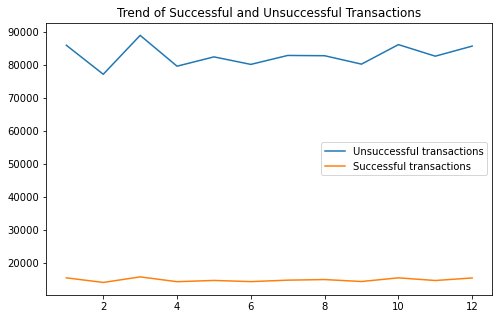

In [51]:
plt.figure(figsize=(8, 5))
plt.plot(byMontherror['Month'], byMonth['code'], label = "Unsuccessful transactions")
plt.plot(byMonth200['Month'], byMonth200['code'], label = "Successful transactions")
plt.legend()
plt.title("Trend of Successful and Unsuccessful Transactions")
plt.show()

In [52]:
#Grouping trasaction based on hour of day and day of week
dayHour = df.groupby(by=['Day of Week','Hour']).count()['code'].unstack()
dayHour.head()

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Day of Week,,,,,,,,,,,,,,,,,,,,,
Fri,6031,5752,5935,5975,5922,6032,6008,6006,5957,6028,...,6034,5782,5911,5856,5884,5917,5885,6085,5891,5907
Mon,6034,5845,5851,5771,5913,5922,6051,5871,5916,5964,...,5767,5915,5758,5977,5902,5951,5886,5932,5972,5972
Sat,5825,5932,5881,5983,6083,5867,5937,6029,5958,5983,...,5901,5964,5856,5853,6027,6005,6026,5969,5851,5867
Sun,5868,5800,5984,6011,5951,5833,5969,5912,6007,5994,...,5924,5970,6062,6017,5873,5855,5921,5837,6033,5863
Thu,5898,5924,5885,5932,5948,5818,5822,5861,5986,5756,...,5852,6117,5877,5944,5867,5940,6028,5902,5940,6001


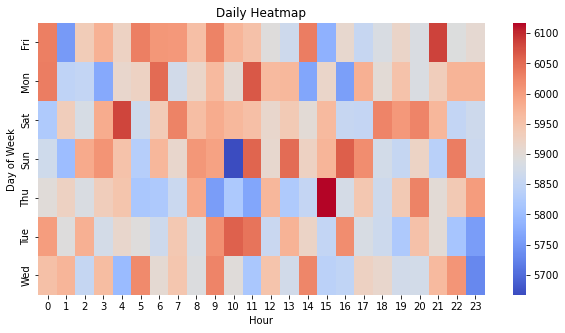

In [53]:
plt.figure(figsize=(10, 5))
sns.heatmap(dayHour,cmap='coolwarm').set_title("Daily Heatmap")
plt.show()

In [54]:
#Grouping trasaction based on month and day of week.
dayMonth = df.groupby(by=['Day of Week','Month']).count()['code'].unstack()
dayMonth.head()

Month,1,2,3,4,5,6,7,8,9,10,11,12
Day of Week,,,,,,,,,,,,
Fri,9598,11386,11955,14592,9062,11828,12278,11186,14329,9771,11820,14677
Mon,14556,11729,12029,9100,14385,9242,11805,12456,11273,14005,10045,11447
Sat,12726,9169,11952,13958,9990,11260,14825,9057,11873,12665,11056,14039
Sun,14594,9525,11978,11180,14942,9045,14086,9617,11717,14630,9234,11820
Thu,8974,11777,14202,12361,8937,13954,9537,11672,12387,11670,11638,14568


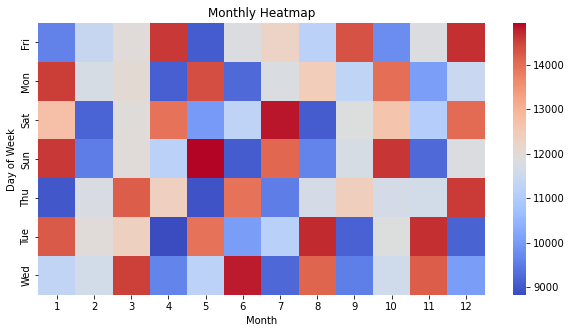

In [55]:
plt.figure(figsize=(10, 5))
sns.heatmap(dayMonth,cmap='coolwarm').set_title("Monthly Heatmap")
plt.show()

### Loss Money For ERROR By Provider Name

In [56]:
def loss_money_by_provider(pname):
    if pname not in df["providerName"].unique():
        raise Exception(f"This provider name {pname} doesnt exists in provider names list.")
    lost_money = df[(df["log_level"] == "ERROR") & (df["providerName"] == pname)]["Price"].sum()
    fig = go.Figure()
    fig.add_trace(go.Indicator(
    mode = "number+delta",
    value = lost_money,
    domain = {'row': 0, 'column': 1}))
    fig.update_layout(autosize=False,
    width=400,
    height=400,
        title={
        'text': f"Loss Money for {pname}",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
    )
    fig.show()

The `loss_money_by_provider(pname)` function calculates the total loss of money for a specific provider in the dataset. It checks if the provider name exists in the dataset, calculates the sum of "Price" values for entries with "ERROR" log level and matching provider name, and creates an Indicator chart using Plotly to display the total loss of money. The chart's title is customized with the provider name, and it is displayed.

In [57]:
loss_money_by_provider("provider_186")

Notify Providers who having Gold plan but *don't serve well*.

### Export Data to use in Power BI and Superset

In [58]:
df.to_parquet("api_management_final.parquet")